In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name

seed = 10599
aqua_globals.random_seed = seed

import sys
import os
from pathlib import Path
import pickle
import numpy as np
import sklearn.model_selection as model_selection
main_folder=str(Path.cwd().parent) 
sys.path.append(main_folder) 
data_folder = f'{main_folder}/data'


## Loading the processed data DR16_Processed

In [3]:
#Load the data
with open(f'{data_folder}/processed/DR16_processed_X.pkl','rb') as input_file:
    X = pickle.load(input_file)
with open(f'{data_folder}/processed/DR16_processed_y.pkl','rb') as input_file:
    y = pickle.load(input_file)



In [49]:
# Create binary target for 1st trial
y_star = y.apply(lambda x: "STAR" if x == "STAR" else "NOT_STAR")
class_labels_Star = list(set(y_star))
y_star_num =  y_star.apply(lambda x: 1 if x == "STAR" else 0)

In [69]:
#Create training_dataset and test_dataset with STAR and NOT_STAR
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_star_num, train_size=0.0004, test_size=0.9996, random_state=101)

X_test_40 = X_test.iloc[:40].copy()
y_test_40 = y_test.iloc[:40].copy()

X_test_extra = X_test.iloc[41:81].copy()
y_test_extra = y_test.iloc[41:81].copy()





In [80]:
(X_test_40[y_test_40 == k, :])[:40]

array([[ 0.10932556, -0.10506629],
       [ 0.43648201, -0.12605385],
       [ 0.07753197,  0.18560868],
       [-0.04325478,  0.33192944],
       [ 0.09902487,  0.40261641],
       [-0.13184299, -0.18573106],
       [ 0.49958018, -0.13869886],
       [ 0.36103661, -0.17662537],
       [-0.16855578,  0.22110089],
       [ 0.10039272, -0.31458376],
       [-0.35427087,  0.49679502],
       [-0.19628565,  0.08378026],
       [ 0.00586043, -0.16790297],
       [ 0.2103063 ,  0.03647273],
       [ 0.15125025,  0.19078307],
       [-0.07050999,  0.32077813]])

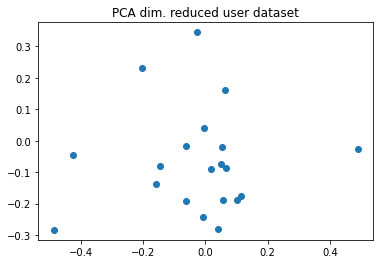

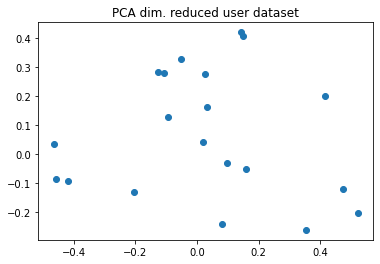

In [82]:
# Now reduce number of features to number of qubits
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test_40 = pca.transform(X_test_40)
X_test_extra = pca.transform(X_test_extra)

# If class labels are numeric
training_size = 40
test_size = 40
test_size_extra = 40

if class_labels_Star[0].isdigit():
        # Pick training size number of samples from each distro
    training_input = {key: (X_train[y_train == int(key), :])[:training_size] for k, key in enumerate(class_labels_Star)}
    test_input_extra = {key: (X_test_extra[y_test_extra == int(key), :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test == int(key), :])[: test_size] for k, key in enumerate(class_labels_Star)}
else:
    # if they aren't
    training_input = {key: (X_train[y_train == k, :])[:training_size] for k, key in enumerate(class_labels_Star)}
    test_input_extra = {key: (X_test_extra[y_test_extra == k, :])[:test_size_extra] for k, key in enumerate(class_labels_Star)}
    test_input = {key: (X_test_40[y_test_40 == k, :])[:test_size] for k, key in enumerate(class_labels_Star)}


for k in range(0, 2):
    plt.scatter(X_train[y_train == k, 0][:training_size],
    X_train[y_train == k, 1][:training_size])
       
    plt.title("PCA dim. reduced user dataset")
    plt.show()   

In [83]:
test_input_extra[0]

KeyError: 0

 QSVM
 """
        Args:
            feature_map: Feature map module, used to transform data
            training_dataset: Training dataset.
            test_dataset: Testing dataset.
            datapoints: Prediction dataset.
            multiclass_extension: If number of classes is greater than 2 then a multiclass scheme
                must be supplied, in the form of a multiclass extension.
            lambda2: L2 norm regularization factor
            quantum_instance: Quantum Instance or Backend

In [84]:
# from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
# sample_total, training_input, test_input, class_labels = ad_hoc_data(
#     training_size=20, 
#     test_size=10, 
#     n=feature_dim, 
#     gap=0.3, 
#     plot_data=True
# )
# extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
# datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
# print(class_to_label)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

qsvm = QSVM(feature_map, training_input, test_input, test_input_extra)

In [85]:
# from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data

feature_dim = 2
# sample_total, training_input, test_input, class_labels = ad_hoc_data(
#     training_size=20, 
#     test_size=10, 
#     n=feature_dim, 
#     gap=0.3, 
#     plot_data=True
# )
# extra_test_data = sample_ad_hoc_data(sample_total, 10, n=feature_dim)
# datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
# print(class_to_label)

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')

qsvm = QSVM(feature_map, training_input, test_input, test_input_extra)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

NameError: The CVXPY package is required to use the optimize_svm() function. You can install it with 'pip install qiskit-aqua[cvx]'.

In [120]:
X_train.head()


,redshift,z,i,r,g,u,ra,dec
21459,0.000702,0.390485,0.348122,0.351658,0.743326,0.852999,0.439842,0.177387
3748,0.009181,0.337557,0.314711,0.331357,0.761997,0.979316,0.676968,0.670082
71919,0.000581,0.378313,0.338266,0.342390,0.736384,0.851937,0.318373,0.830189
77257,0.000540,0.361873,0.323012,0.323748,0.681131,0.776810,0.493428,0.472090
91639,0.008135,0.288520,0.271083,0.285749,0.652983,0.843648,0.588636,0.423366


In [121]:
y.head()

0      STAR
1      STAR
2      STAR
3    GALAXY
4    GALAXY
Name: class, dtype: object

In [108]:
training_input

{'A': array([[1.75929189, 2.136283  ],
        [4.0212386 , 3.14159265],
        [2.89026524, 5.02654825],
        [2.76460154, 4.64955713],
        [5.96902604, 0.87964594],
        [1.00530965, 6.1575216 ],
        [0.25132741, 5.34070751],
        [2.38761042, 1.50796447],
        [2.95309709, 5.52920307],
        [0.18849556, 0.12566371],
        [3.95840674, 5.02654825],
        [2.38761042, 1.69646003],
        [1.25663706, 0.18849556],
        [0.        , 2.38761042],
        [4.90088454, 5.34070751],
        [1.44513262, 0.75398224],
        [2.26194671, 2.95309709],
        [5.46637122, 4.96371639],
        [2.70176968, 3.20442451],
        [5.78053048, 1.69646003]]),
 'B': array([[1.0681415 , 5.15221195],
        [2.38761042, 6.22035345],
        [5.15221195, 2.89026524],
        [0.18849556, 3.70707933],
        [0.9424778 , 4.90088454],
        [5.27787566, 4.58672527],
        [5.2150438 , 5.65486678],
        [5.59203492, 0.31415927],
        [4.64955713, 0.62831853],
  

In [ ]:
training_input_star = {"STAR":}

In [77]:
y_star =y.apply(lambda x: 1 if x == "STAR" else 0)
class_to_label_star = {'START':1,'NOT STAR':0}

In [47]:
class_to_label_new

{'A': 0, 'B': 1}

In [10]:
from qiskit.aqua.utils import split_dataset_to_data_and_labels 
data_train, _ = split_dataset_to_data_and_labels(X_2)
data_test, _ = split_dataset_to_data_and_labels(test_input)  # %%Breast Cancer dataset



NameError: name 'test_input' is not defined

In [97]:
# from qiskit import Aer
# from qiskit.aqua.input import SVMInput
# from qiskit.aqua import run_algorithm
# import numpy as np

# n = 2  # dimension of each data point
# #sample_Total, training_input, test_input, class_labels = Wine(training_size=40,test_size=10, n=n, PLOT_DATA=True)

# temp = [X_test_20[k] for k in X_test_20]
# total_array = np.concatenate(temp)

# aqua_dict = {'problem': {'name': 'svm_classification', 'random_seed': 10598},'algorithm': {'name': 'QSVM.Kernel'},'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entangler_map': {0: [1]}},'multiclass_extension': {'name': 'AllPairs'},'backend': {'shots': 1024}}

# backend = Aer.get_backend('qasm_simulator')
# algo_input = SVMInput(X_train, X_test_20, total_array)
# result = run_algorithm(aqua_dict, algo_input, backend=backend)
# for k,v in result.items():
#     print("'{}' : {}".format(k, v))

ModuleNotFoundError: No module named 'qiskit.aqua.input'

In [ ]:
def userDefinedData(location, file, class_labels,training_size, test_size, n=2, PLOT_DATA=True):


    data, target, target_names = load_data(location, file)
    # sample_train is of the same form as data
    sample_train, sample_test, label_train, label_test = train_test_split(
        data, target,test_size=0.25, train_size=0.75 ,random_state=22)


    # # Now we standarize for gaussian around 0 with unit variance
    # std_scale = StandardScaler().fit(sample_train)
    # sample_train = std_scale.transform(sample_train)
    # sample_test = std_scale.transform(sample_test)


    # # Now reduce number of features to number of qubits
    # pca = PCA(n_components=n).fit(sample_train)
    # sample_train = pca.transform(sample_train)
    # sample_test = pca.transform(sample_test)


    # # Samples are pairs of points
    # samples = np.append(sample_train, sample_test, axis=0)
    # minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    # sample_train = minmax_scale.transform(sample_train)
    # sample_test = minmax_scale.transform(sample_test)


    # If class labels are numeric
    if class_labels[0].isdigit():
        # Pick training size number of samples from each distro
        training_input = {key: (sample_train[label_train == int(key), :])[:training_size] for k, key in enumerate(class_labels)}
        test_input = {key: (sample_test[label_test == int(key), :])[: test_size] for k, key in enumerate(class_labels)}

    else:
        # if they aren't
        training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in
                         enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
                training_size + test_size)] for k, key in enumerate(class_labels)}



    if PLOT_DATA:
        for k in range(0, 9):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced user dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

With the dataset ready we can setup the [QSVM](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.QSVM.html) algorithm to do a classification. Here we use the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) data encoding circuit from the Qiskit circuit library.

Here the BasicAer `qasm_simulator` is used with 1024 shots.

For the testing, the result includes the details and the success ratio. For the prediction, the result includes the predicted labels. 

Testing success ratio: 1.0

Prediction from datapoints set:
  ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
  success rate: 100.0%


The following shows the kernel matrix that was built from the training sample of the dataset.

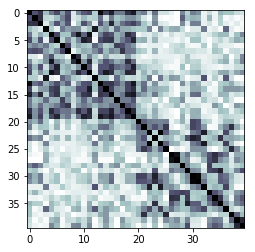

In [4]:
kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r');

Qiskit also has a classical SVM implementation that takes the same input data for classification. Let's run this and do a comparison. Now the ad hoc data set was created to show that there can be datasets where quantum could give an advantage.

In [98]:
from qiskit.aqua.algorithms import SklearnSVM

result = SklearnSVM(training_input, test_input, datapoints[0]).run()

print(f'Testing success ratio: {result["testing_accuracy"]}')
print()
print('Prediction from datapoints set:')
print(f'  ground truth: {map_label_to_class_name(datapoints[1], qsvm.label_to_class)}')
print(f'  prediction:   {result["predicted_classes"]}')
predicted_labels = result["predicted_labels"]
print(f'  success rate: {100*np.count_nonzero(predicted_labels == datapoints[1])/len(predicted_labels)}%')

kernel_matrix = result['kernel_matrix_training']
plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r');

NameError: The CVXPY package is required to use the optimize_svm() function. You can install it with 'pip install qiskit-aqua[cvx]'.